In [1]:
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
df=pd.read_csv('training.csv')
#make all strings
df['article_words']=df['article_words'].apply(str)

#get rid of commas/punctuation
punctuation_signs = list("?:!.,;")
df['article_words_parse_1'] = df['article_words']

for punct_sign in punctuation_signs:
    df['article_words_parse_1'] = df['article_words_parse_1'].str.replace(punct_sign, ' ')
    
#all lower case
df['article_words_parse_2'] = df['article_words_parse_1'].str.lower()

#NO STEMMING NO LEMMISATION, NO STOP WORDS

#Category Numbers
category_codes = {
    'ARTS CULTURE ENTERTAINMENT': 0,
    'BIOGRAPHIES PERSONALITIES PEOPLE': 1,
    'DEFENCE': 2,
    'DOMESTIC MARKETS': 3,
    'FOREX MARKETS': 4,
    'HEALTH': 5,
    'IRRELEVANT': 6,
    'MONEY MARKETS': 7,
    'SCIENCE AND TECHNOLOGY': 8,
    'SHARE LISTINGS': 9,
    'SPORTS': 10
}

# Category mapping
df['Category_Code'] = df['topic']
df = df.replace({'Category_Code':category_codes})


df = df.drop(["article_words", "article_words_parse_1"], axis=1)


print(df)

      article_number          topic  \
0                  1  FOREX MARKETS   
1                  2  MONEY MARKETS   
2                  3         SPORTS   
3                  4  FOREX MARKETS   
4                  5     IRRELEVANT   
...              ...            ...   
9495            9496        DEFENCE   
9496            9497     IRRELEVANT   
9497            9498  FOREX MARKETS   
9498            9499     IRRELEVANT   
9499            9500  FOREX MARKETS   

                                  article_words_parse_2  Category_Code  
0     open absent cent cent cent stock inflow rate k...              4  
1     morn stead end end day day day patch patch pat...              7  
2     socc socc world world recent law fifa fifa fif...             10  
3     open forint forint forint forint cent cent ste...              4  
4     morn complet weekend minut minut minut arrow d...              6  
...                                                 ...            ...  
9495  cloud provid h

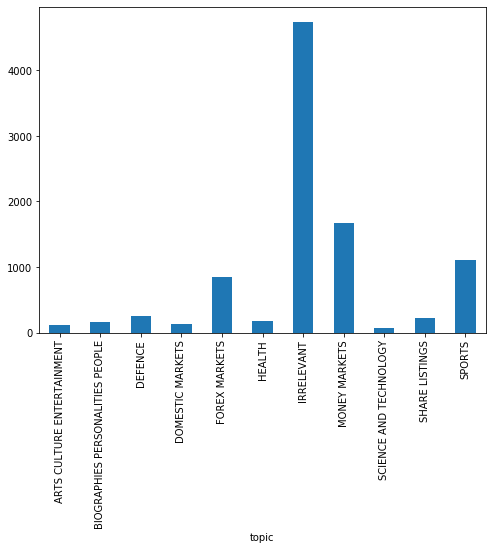

In [3]:
#Data Analysis
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('topic').article_words_parse_2.count().plot.bar(ylim=0)
plt.show()

In [4]:
print(df)

      article_number          topic  \
0                  1  FOREX MARKETS   
1                  2  MONEY MARKETS   
2                  3         SPORTS   
3                  4  FOREX MARKETS   
4                  5     IRRELEVANT   
...              ...            ...   
9495            9496        DEFENCE   
9496            9497     IRRELEVANT   
9497            9498  FOREX MARKETS   
9498            9499     IRRELEVANT   
9499            9500  FOREX MARKETS   

                                  article_words_parse_2  Category_Code  
0     open absent cent cent cent stock inflow rate k...              4  
1     morn stead end end day day day patch patch pat...              7  
2     socc socc world world recent law fifa fifa fif...             10  
3     open forint forint forint forint cent cent ste...              4  
4     morn complet weekend minut minut minut arrow d...              6  
...                                                 ...            ...  
9495  cloud provid h

In [7]:
X_train, X_test, y_train, y_test= train_test_split(df['article_words_parse_2'], 
                                                    df['Category_Code'],
                                                    random_state=8)

In [8]:
#TFIDF
# Parameter election
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 6000

tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)


(7125, 6000)
(2375, 6000)


The training accuracy is: 
0.7688421052631579
The test accuracy is: 
0.736
Classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       1.00      0.08      0.15        37
           2       0.65      0.25      0.37        67
           3       0.00      0.00      0.00        31
           4       0.70      0.08      0.14       245
           5       0.57      0.09      0.16        43
           6       0.79      0.91      0.84      1191
           7       0.56      0.91      0.69       387
           8       0.00      0.00      0.00        19
           9       1.00      0.04      0.08        50
          10       0.89      0.97      0.93       277

    accuracy                           0.74      2375
   macro avg       0.56      0.30      0.31      2375
weighted avg       0.73      0.74      0.68      2375



C:\Users\Stephen Sung\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


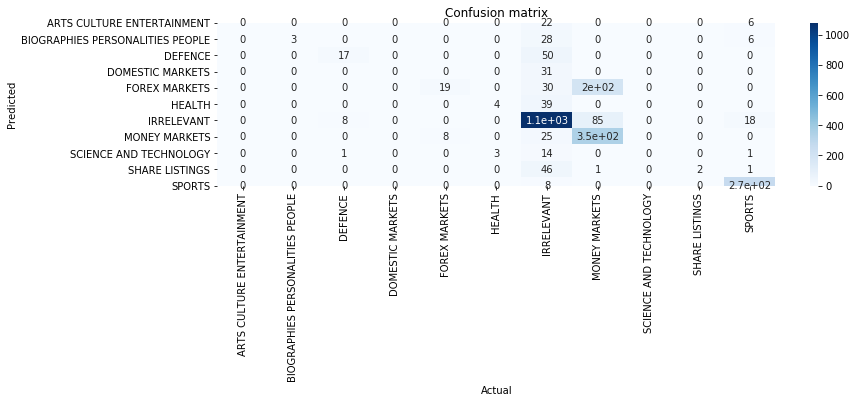

In [11]:
from sklearn.naive_bayes import MultinomialNB
#MNB
mnbc = MultinomialNB()

#clf = mnbc.fit(features_train, labels_train)
mnbc.fit(features_train, labels_train)
mnbc_pred = mnbc.predict(features_test)

print("The training accuracy is: ")
print(accuracy_score(labels_train, mnbc.predict(features_train)))

print("The test accuracy is: ")
print(accuracy_score(labels_test, mnbc_pred))

print("Classification report")
print(classification_report(labels_test,mnbc_pred))

aux_df = df[['topic', 'Category_Code']].drop_duplicates().sort_values('Category_Code')
conf_matrix = confusion_matrix(labels_test, mnbc_pred)
plt.figure(figsize=(12.5,3))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['topic'].values, 
            yticklabels=aux_df['topic'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [12]:
testing_predictions1 = []
for i in range(len(X_test)):
    if mnbc_pred[i] == 0:
        testing_predictions1.append('ARTS CULTURE ENTERTAINMENT')
    elif mnbc_pred[i] == 1:
        testing_predictions1.append('BIOGRAPHIES PERSONALITIES PEOPLE')
    elif mnbc_pred[i] == 2:
        testing_predictions1.append('DEFENCE')
    elif mnbc_pred[i] == 3:
        testing_predictions1.append('DOMESTIC MARKETS')
    elif mnbc_pred[i] == 4:
        testing_predictions1.append('FOREX MARKETS')
    elif mnbc_pred[i] == 5:
        testing_predictions1.append('HEALTH')
    elif mnbc_pred[i] == 6:
        testing_predictions1.append('IRRELEVANT')
    elif mnbc_pred[i] == 7:
        testing_predictions1.append('MONEY MARKETS')
    elif mnbc_pred[i] == 8:
        testing_predictions1.append('SCIENCE AND TECHNOLOGY')
    elif mnbc_pred[i] == 9:
        testing_predictions1.append('SHARE LISTINGS')
    elif mnbc_pred[i] == 10:
        testing_predictions1.append('SPORTS')
    else:
        testing_predictions1.append('ERROR')
check_df1 = pd.DataFrame({'actual_label': list(y_test), 'prediction': testing_predictions1})
check_df1.actual_label.replace(to_replace=0, value='ARTS CULTURE ENTERTAINMENT', inplace=True)
check_df1.actual_label.replace(to_replace=1, value='BIOGRAPHIES PERSONALITIES PEOPLE', inplace=True)
check_df1.actual_label.replace(to_replace=2, value='DEFENCE', inplace=True)
check_df1.actual_label.replace(to_replace=3, value='DOMESTIC MARKETS', inplace=True)
check_df1.actual_label.replace(to_replace=4, value='FOREX MARKETS', inplace=True)
check_df1.actual_label.replace(to_replace=5, value='HEALTH', inplace=True)
check_df1.actual_label.replace(to_replace=6, value='IRRELEVANT', inplace=True)
check_df1.actual_label.replace(to_replace=7, value='MONEY MARKETS', inplace=True)
check_df1.actual_label.replace(to_replace=8, value='SCIENCE AND TECHNOLOGY', inplace=True)
check_df1.actual_label.replace(to_replace=9, value='SHARE LISTINGS', inplace=True)
check_df1.actual_label.replace(to_replace=10, value='SPORTS', inplace=True)

In [13]:
check_df1[check_df1.prediction == 'ARTS CULTURE ENTERTAINMENT'].shape[0]

0